In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec

import sys
sys.path.append('../src')  # Go one level up and then into src
from SMF import SMF_BCD, SMF_LPGD, rank_r_projection, compute_accuracy_metrics
from SMF_torch import smf

/Users/hanbaek/opt/miniconda3/envs/hlyuenv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/hanbaek/opt/miniconda3/envs/hlyuenv/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <3F789787-FE38-3CE7-8599-064BDD0416EE> /Users/hanbaek/opt/miniconda3/envs/hlyuenv/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <D983C0C6-7C01-3D9C-A96B-07BB20D2CE66> /Users/hanbaek/opt/miniconda3/envs/hlyuenv/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


# Microarray Cancer Data

## Read data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("whitegrid")

#sys.path.append('../data')  # Go one level up and then into src

"""
data = pd.read_csv('../Data/Breast_GSE70947.csv')
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
print("X.shape=", X.shape)

"""

data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
y = data['type'].values
y = [1 if y[i] == 'tumoral' else 0 for i in range(len(y))]
y = np.array(y)
X0 = data.drop(columns=['samples', 'type']).values
X = (X0 - np.mean(X0, axis = 0))/(100*np.std(X0, axis = 0)) # normalization
#X = 10*X0/np.linalg.norm(X0)
print("X.shape=", X.shape) # X.shape = [num of samples, num of features]
print("y.shape=", y.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = np.asarray([Y_train]), np.asarray([Y_test])
covariate_train, covariate_test = None, None

gene_list0 = data.keys()
gene_list = gene_list0[2:]

X.shape= (51, 54675)
y.shape= (51,)


## SMF-W

### Use Block Coordiante Descent to fit SMF-W

In [3]:
r = 2 # number of latent gene groups
xi = 1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100


U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_BCD_class = SMF_BCD(X=[X_train, Y_train],  # data, label
                            X_test=[X_test, Y_test], 
                            n_components=r,  
                            ini_loading=W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            ini_code = H0,
                            xi=xi,  # weight on label reconstruction error
                            nonnegativity=[False,False,False]) # nonnegativity constraints on code H, dictionary W[0], reg params W[1]

results_dict = SMF_BCD_class.fit(iter=iteration, subsample_size=None,
                                    option = "filter",
                                    if_compute_recons_error=True, if_validate=False)

results_dict.update({'method': 'SMF-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[ 0.36726331 -0.02878745 -0.47538939]]


  1%|▍                                      | 1/100 [00:00<00:10,  9.90it/s]

--- Training --- [threshold, AUC] =  [0.744, 0.917]
--- Iteration 0: Training loss --- [Data, Label, Total] = [94.821818.3, 10.899913.3, 105.721731.3]


 17%|██████▍                               | 17/100 [00:00<00:02, 37.45it/s]

--- Training --- [threshold, AUC] =  [0.647, 0.931]
--- Iteration 10: Training loss --- [Data, Label, Total] = [89.081629.3, 9.558610.3, 98.640239.3]


 25%|█████████▌                            | 25/100 [00:00<00:02, 34.18it/s]

--- Training --- [threshold, AUC] =  [0.645, 0.944]
--- Iteration 20: Training loss --- [Data, Label, Total] = [89.321078.3, 8.971016.3, 98.292095.3]


 34%|████████████▉                         | 34/100 [00:01<00:02, 29.52it/s]

--- Training --- [threshold, AUC] =  [0.643, 0.944]
--- Iteration 30: Training loss --- [Data, Label, Total] = [89.499156.3, 8.572759.3, 98.071914.3]


 46%|█████████████████▍                    | 46/100 [00:01<00:01, 30.19it/s]

--- Training --- [threshold, AUC] =  [0.567, 0.951]
--- Iteration 40: Training loss --- [Data, Label, Total] = [89.630353.3, 8.289710.3, 97.920063.3]


 60%|██████████████████████▊               | 60/100 [00:02<00:01, 27.97it/s]

--- Training --- [threshold, AUC] =  [0.568, 0.951]
--- Iteration 50: Training loss --- [Data, Label, Total] = [89.729798.3, 8.081110.3, 97.810909.3]


 69%|██████████████████████████▏           | 69/100 [00:02<00:00, 33.00it/s]

--- Training --- [threshold, AUC] =  [0.569, 0.951]
--- Iteration 60: Training loss --- [Data, Label, Total] = [89.807278.3, 7.922634.3, 97.729912.3]


 73%|███████████████████████████▋          | 73/100 [00:02<00:01, 25.43it/s]

--- Training --- [threshold, AUC] =  [0.569, 0.958]
--- Iteration 70: Training loss --- [Data, Label, Total] = [89.869037.3, 7.799011.3, 97.668047.3]


 87%|█████████████████████████████████     | 87/100 [00:02<00:00, 34.59it/s]

--- Training --- [threshold, AUC] =  [0.57, 0.958]
--- Iteration 80: Training loss --- [Data, Label, Total] = [89.919136.3, 7.701821.3, 97.620957.3]
--- Training --- [threshold, AUC] =  [0.57, 0.958]
--- Iteration 90: Training loss --- [Data, Label, Total] = [89.960453.3, 7.621845.3, 97.582299.3]


100%|█████████████████████████████████████| 100/100 [00:03<00:00, 30.52it/s]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.571, 0.965]


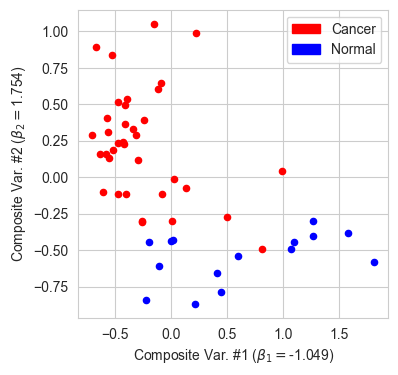

In [4]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot1", bbox_inches="tight", dpi=300)

In [5]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

latent gene groups = 
[[-0.00248332  0.00675482]
 [-0.00323248  0.00216407]
 [-0.00312007  0.00647002]
 ...
 [ 0.00327662 -0.00159858]
 [ 0.0036071  -0.00109095]
 [ 0.0020849   0.00152207]]
regression coefficients associated to the latent gene groups = [-1.04948923  1.75363914]
intercept term = 0.8254254058777243


### Use Low-rank Projected Gradient Descent to fit SMF-W

In [6]:
r = 2 # number of latent gene groups
xi = 1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100

U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_LPGD_class = SMF_LPGD(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        ini_loading = W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        ini_code = H0,
                        xi=xi)  # weight on label reconstruction error
                       

results_dict = SMF_LPGD_class.fit(iter=iteration, 
                                    beta = 0,
                                    nu = 0,
                                    stepsize=0.01,
                                    if_compute_recons_error=False, if_validate=False)

results_dict.update({'method': 'SDL-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[ 0.09609713 -0.03189441  0.45323108]]


  5%|█▉                                     | 5/100 [00:15<05:01,  3.17s/it]


KeyboardInterrupt: 

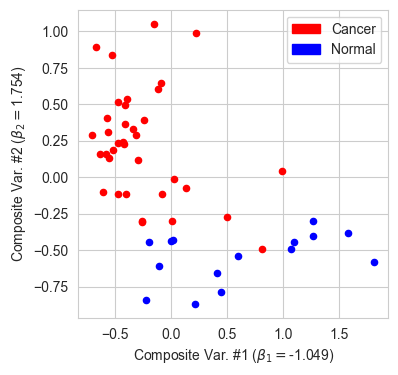

In [7]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot2", bbox_inches="tight", dpi=300)

In [ ]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

### Use Pytorch implementation of BCD to fit SMF-W (utilizes GPU if possible)

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.autograd import Variable

"""
#data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
data = pd.read_csv('../Data/Breast_GSE70947.csv')

print(data.shape)
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
y = np.array(y)
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
"""


hidden_size = 2

Accuracy = []
test_size = 0.5

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(Y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(Y_test)).long()
print(f"y_train's ndim: {y_train.ndim}")

smf_model = smf(X_train, y_train, hidden_size, device='cuda')
results_dict = smf_model.fit(num_epochs=100,
               lr_classification=0.01,
               lr_matrix_factorization=0.01,
               xi=1,
               initialize='spectral',
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test, y_test],
               record_recons_error=True)
Accuracy.append(smf_model.test(X_test, y_test))

y_train's ndim: 1
Epoch [10/100],Loss_Classification: 0.3234 Loss_MF: 0.0001
mythre= 0.5
mythre_test= 0.66547966
Test accuracy = 0.923, Test AUC = 0.95
--- Training --- [threshold, AUC] =  [0.712, 0.965]
--- Iteration 9: Training loss --- [Data, Label, Total] = [86.005699.3, 7.817085.3, 93.822784.3]
Epoch [20/100],Loss_Classification: 0.2641 Loss_MF: 0.0001
mythre= 0.7120616
mythre_test= 0.6058653
Test accuracy = 0.808, Test AUC = 0.958
--- Training --- [threshold, AUC] =  [0.752, 0.986]
--- Iteration 19: Training loss --- [Data, Label, Total] = [85.870081.3, 6.542170.3, 92.412251.3]
Epoch [30/100],Loss_Classification: 0.2492 Loss_MF: 0.0001
mythre= 0.7520403
mythre_test= 0.60367167
Test accuracy = 0.808, Test AUC = 0.95
--- Training --- [threshold, AUC] =  [0.769, 0.993]
--- Iteration 29: Training loss --- [Data, Label, Total] = [85.420498.3, 6.210686.3, 91.631184.3]
Epoch [40/100],Loss_Classification: 0.2433 Loss_MF: 0.0001
mythre= 0.7686454
mythre_test= 0.579304
Test accuracy = 0.80

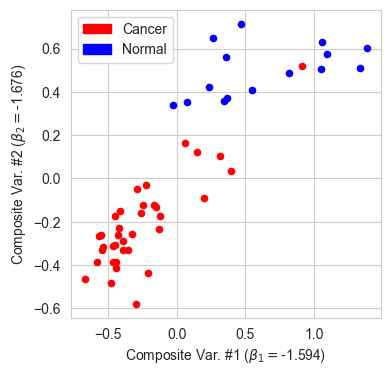

In [11]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot2", bbox_inches="tight", dpi=300)